## Partial pipelines

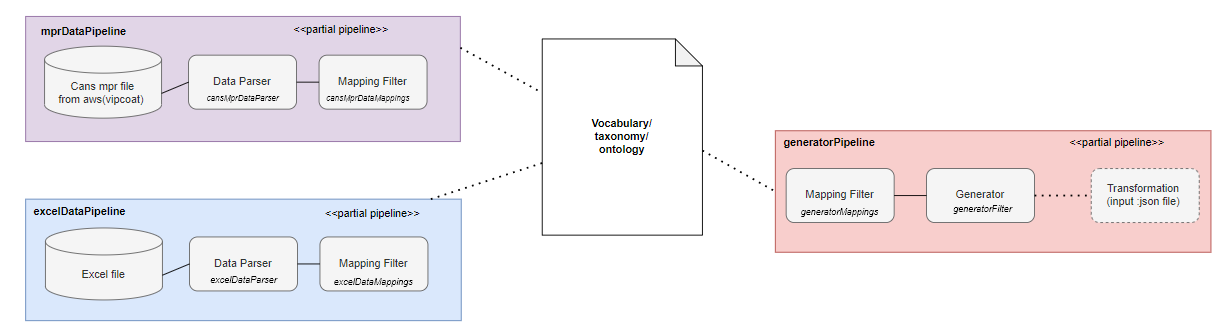

## case 1: The transformation requires files in Json format, and need data from an mpr file !

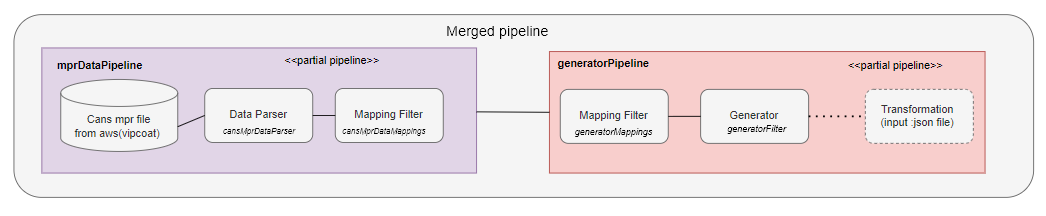

## case 2: The transformation requires files in Json format, and need data from an excel file

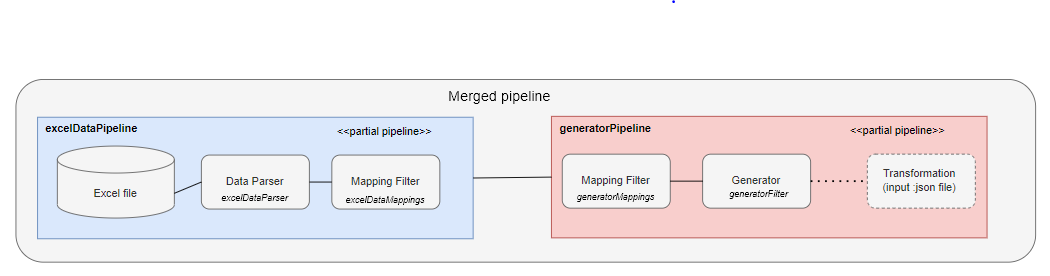

## Build and store the first Partial Pipeline : mprDataPipeline
#### This contains a filter that parses the Cans data in mpr format and a mapping filter that adds the mappings (metadata of mpr data to ontological concepts) 


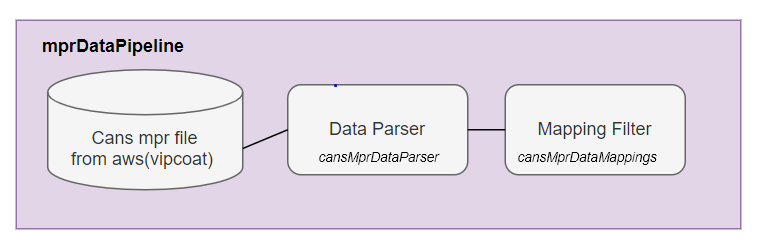


In [1]:
from oteutils.kb import *
from oteutils.utils import *
# Connect to the OTEAPI services
client = OTEPipelines(url='http://localhost:8080')

In [2]:
# Create configurations for filters

# Resource Config for mpr files
cansDataConfig = ResourceConfig(    
    downloadUrl="https://vipcoat-bucket.s3.eu-west-2.amazonaws.com/experiments/raw/2-amino-4-methylthiazole|CC1=CSC(=N1)N/101022_1mM_2amino4methylthiazole_run1/101022_1mM_2amino4methylthiazole_run1_11_PEIS_C01.mpr",
    mediaType="application/parse-mpr",
    configuration={
        "mpr_config":{
                    'Time': 'time/s',
                    'Electrode_potential': '<Ewe>/V',
                    'Frequency': 'freq/Hz',
                    'Impedance_real': 'Re(Z)/Ohm',
                    'Impedance_img': '-Im(Z)/Ohm',
                    'Absolute_Impedance': '|Z|/Ohm',
                    'Impedance_Phase': 'Phase(Z)/deg',                
        },
        "metadata": "http://onto-ns.com/meta/vipcoat/demo/0.2/EIS" ,
        "storage_path": "/dome_demo/models" ,
        "label":"mpr-data"
    }
)

# Fetch mappings as triples from .ttl file
tsp=Triplestore(backend="rdflib")
tsp.parse('./mappings/Vipcoat_EIS.ttl')
mprDataMappings=[]
for (s, p, o) in tsp.triples(None,MAP.mapsTo,None): 
    mprDataMappings.append((s, p, o))
# print(mprDataMappings)

# Mapping configuration for the mapping filter
cansDataMappingsMpr = MappingConfig(
    mappingType="mappings",
    triples = mprDataMappings,
    configuration={
    }     
)

# Create fiters
cansMprDataParser= client.create_dataresource(cansDataConfig)
cansMprDataMappings = client.create_mapping(cansDataMappingsMpr)

# Build Pipeline
mprDataPipeline =cansMprDataParser >> cansMprDataMappings 

# Store Pipeline
client.store_pipeline(mprDataPipeline)

## Build and store second pipeline : excelDataPipeline

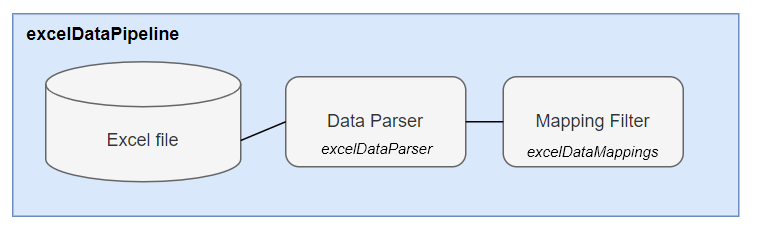

#### This contains a excel parser that takes in data in excel format and a mapping filter that adds the mappings (metadata of excel data to ontological concepts) 

In [3]:
# Create configurations for filters

# Resource Config for excel files
excelDataConfig = ResourceConfig( 
    downloadUrl="file:///dome_demo/data/vipcoatEIS.xlsx",
    mediaType="application/vnd.dlite-xlsx",
    configuration={
        'excel_config':{
            'worksheet':'EIS_VALUES',  
            "header_row": "1",
            "row_from": "2",
            "row_to":"10"
        },
      "metadata": "http://onto-ns.com/meta/vipcoat/demo/0.2/EIS" ,
    "storage_path": "/dome_demo/models/vipcoat_EIS_properties.json" ,
    }
)


# Fetch mappings as triples from .ttl file
tsp=Triplestore(backend="rdflib")
tsp.parse('./mappings/Vipcoat_EIS.ttl')
excelDataMappings=[]
for (s, p, o) in tsp.triples(None,MAP.mapsTo,None): 
    excelDataMappings.append((s, p, o))
# print(excelDataMappings)

# Mapping configuration for the mapping filter
dataMappingsExcel = MappingConfig(
    mappingType="mappings",
    triples = excelDataMappings,
    configuration={
    }     
)

# Create filters
excelDataParser = client.create_dataresource(excelDataConfig)
excelDataMappings = client.create_mapping(dataMappingsExcel)

# Build Pipeline
excelDataPipeline =excelDataParser >> excelDataMappings 

# Store Pipeline
client.store_pipeline(excelDataPipeline)

## Build and store third pipeline : generatorPipeline

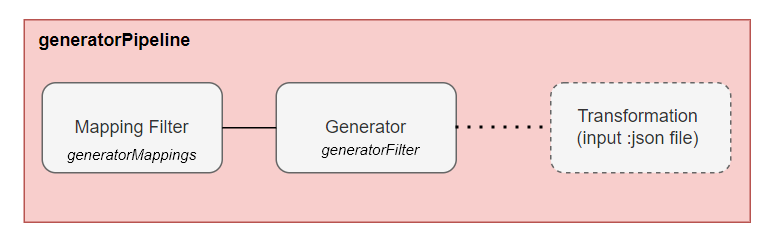

#### This contains a mapping filter that adds the mappings (metadata of the required json data to ontological concepts) and a generator filter that fetches the required data when piped to relevant data pipelines

In [4]:
# Create configurations for filters

# Fetch mappings as triples from .ttl file
tsp=Triplestore(backend="rdflib")
tsp.parse('./mappings/Vipcoat_fetch.ttl')
dataMappings=[]
for (s, p, o) in tsp.triples(None,MAP.mapsTo,None): 
    dataMappings.append((s, p, o))
# print(dataMappings)

# Mapping configuration for the mapping filter
generatorMappingConfig = MappingConfig(
    mappingType="mappings",
    triples = dataMappings,
    configuration={
    }     
)

# Configuration that fetches data and stores to a json file
generatorFilterConfig = FunctionConfig(
    functionType="dlite/translate",
    configuration={'metadata':'http://onto-ns.com/meta/vipcoat/demo/0.2/data',
                    'storage_path':"/dome_demo/models/vipcoat_fetch_properties.json",
                   "fileDestination": "/oteapi-dlite/output_dlite.json"} 
)


createcollectionfilter = FilterConfig(
      filterType="dlite/create-collection",
    description="",
    configuration={},
)


# Create Filters
generatorMappings= client.create_mapping(generatorMappingConfig)
generatorFilter=client.create_function(generatorFilterConfig)
createCollection=client.create_filter(createcollectionfilter)

# Build Pipeline
generatorPipeline =generatorMappings >> generatorFilter >> createCollection 



In [5]:
# Store Pipeline
client.store_pipeline(generatorPipeline)

## Fetch Data Pipeline w.r.t resource URL 

In [6]:
# File links given as download urls in the configuration of the data resources

mpr_file="https://vipcoat-bucket.s3.eu-west-2.amazonaws.com/experiments/raw/2-amino-4-methylthiazole|CC1=CSC(=N1)N/101022_1mM_2amino4methylthiazole_run1/101022_1mM_2amino4methylthiazole_run1_11_PEIS_C01.mpr"
excel_file="file:///dome_demo/data/vipcoatEIS.xlsx"

pipe_iri = find_pipeline_by_config_iri(mpr_file)
print(fetch_pipeline(pipe_iri))




# Please connect to: client = OTEPipelines(url='http://localhost:8080') use otelib pypi package

    
        f_1 = client.create_dataresource(ResourceConfig(configuration={'mpr_config': {'Time': 'time/s', 'Electrode_potential': '<Ewe>/V', 'Frequency': 'freq/Hz', 'Impedance_real': 'Re(Z)/Ohm', 'Impedance_img': '-Im(Z)/Ohm', 'Absolute_Impedance': '|Z|/Ohm', 'Impedance_Phase': 'Phase(Z)/deg'}, 'storage_path': '/dome_demo/models/vipcoat_EIS_properties.json', 'metadata': 'http://onto-ns.com/meta/vipcoat/demo/0.2/EIS', 'label': 'mpr-data'},downloadUrl='https://vipcoat-bucket.s3.eu-west-2.amazonaws.com/experiments/raw/2-amino-4-methylthiazole|CC1=CSC(=N1)N/101022_1mM_2amino4methylthiazole_run1/101022_1mM_2amino4methylthiazole_run1_11_PEIS_C01.mpr' ,mediaType='application/parse-mpr'))
    
    
    
    

    
    
         f_2 = client.create_mapping(MappingConfig(configuration={},mappingType='mappings' ,triples=[('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Electrode_potential', 'http://

## Copy the above filter configurations and Pipeline and run with the generator pipeline

In [7]:


# Please connect to: client = OTEPipelines(url='http://localhost:8080') use otelib pypi package

    
f_1 = client.create_dataresource(ResourceConfig(configuration={'storage_path': '/dome_demo/models/vipcoat_EIS_properties.json', 'mpr_config': {'Time': 'time/s', 'Electrode_potential': '<Ewe>/V', 'Frequency': 'freq/Hz', 'Impedance_real': 'Re(Z)/Ohm', 'Impedance_img': '-Im(Z)/Ohm', 'Absolute_Impedance': '|Z|/Ohm', 'Impedance_Phase': 'Phase(Z)/deg'}, 'metadata': 'http://onto-ns.com/meta/vipcoat/demo/0.2/EIS', 'label': 'mpr-data'},downloadUrl='https://vipcoat-bucket.s3.eu-west-2.amazonaws.com/experiments/raw/2-amino-4-methylthiazole|CC1=CSC(=N1)N/101022_1mM_2amino4methylthiazole_run1/101022_1mM_2amino4methylthiazole_run1_11_PEIS_C01.mpr' ,mediaType='application/parse-mpr'))
    
    
    
    

    
    
f_2 = client.create_mapping(MappingConfig(configuration={},mappingType='mappings' ,triples=[('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Impedance_Phase', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#phaseOfImpedance'), ('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Absolute_Impedance', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#absoluteImpedanceValue'), ('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Impedance_real', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#realImpedanceValue'), ('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Impedance_img', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#imginaryImpedanceValue'), ('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Time', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#time'), ('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Electrode_potential', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#electrodePotential'), ('http://onto-ns.com/meta/vipcoat/demo/0.2/EIS#Frequency', 'http://emmo.info/domain-mappings#mapsTo', 'http://onto-ns.com/meta/vipcoat/demo/0.2/properties#frequency')]))
    
    
    

storedPipeline = f_1  >>   f_2     

In [8]:
# Build a new pipeline by merging the fetched one with the generator Pipeline
pipeline = storedPipeline >> generatorPipeline

# Execute the pipeline
pipeline.get()

b'{"collection_id":"fa4118c4-d2a8-4ead-93c8-bf9945c0a130"}'

In [9]:
## Display the data stored in the generated json file

import json
f = open('./oteapi-dlite/output_dlite.json')
data = json.load(f)
f.close()
# print(data)
import pandas as pd
df = pd.DataFrame(data=data)
print(df)

            Time  Potential_of_electrode     Impedence
0   92654.569989               -0.529052    112.829445
1   92655.174059               -0.529120    113.374672
2   92655.729489               -0.529129    114.048653
3   92656.404330               -0.529119    114.723297
4   92657.077331               -0.529125    115.822495
5   92657.750214               -0.529123    116.874512
6   92658.423306               -0.529124    118.185036
7   92659.095065               -0.529131    119.896843
8   92659.767072               -0.529127    121.940933
9   92660.440213               -0.529131    124.201942
10  92661.110945               -0.529131    126.734322
11  92661.783049               -0.529124    129.705872
12  92662.453570               -0.529113    132.988434
13  92663.124687               -0.529111    136.803116
14  92663.794196               -0.529105    141.465561
15  92664.470481               -0.529109    147.100906
16  92665.141450               -0.529117    154.062622
17  92665.